# Using the neural networks to predict the salinity profile from the temperature profile

In [0]:
import numpy as np
#from netCDF4 import Dataset
from matplotlib import pylab as plt
import pandas as pd
import xarray as xr
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit,train_test_split
from mpl_toolkits.basemap import Basemap

%matplotlib inline

# **Import and pre-processing   data**

In [0]:
#!pip install zarr

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from google.colab import files

In [0]:
data=xr.open_zarr('/content/gdrive/My Drive/Colab Notebooks/GLOB_HOMOGENEOUS_variables.zarr')

In [0]:
da_al=data[['PSAL','TEMP']] #(DEPTH: 302, N_PROF: 128910)

In [4]:
da_s=da_al.where((da_al.PSAL <40.)& (da_al.PSAL>25.), drop= True)#
da_s=da_s.dropna('N_PROF')
da_s

<xarray.Dataset>
Dimensions:    (DEPTH: 302, N_PROF: 128904)
Coordinates:
    LATITUDE   (N_PROF) float32 dask.array<shape=(128904,), chunksize=(67007,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(128904,), chunksize=(67007,)>
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1495.0 -1500.0 -1505.0
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(128904,), chunksize=(64452,)>
Dimensions without coordinates: N_PROF
Data variables:
    PSAL       (N_PROF, DEPTH) float32 dask.array<shape=(128904, 302), chunksize=(67007, 302)>
    TEMP       (N_PROF, DEPTH) float32 dask.array<shape=(128904, 302), chunksize=(67007, 302)>
Attributes:
    Title:             VENTHSAL-IA
    conventions:       CF-1.6
    conventions_help:  http://cf-pcmdi.llnl.gov/documents/cf-conventions/1.6/...
    createdBy:         gmaze
    createdWith:       /home8/homedir3/perso/gmaze/work/Projects/GMM/Argo-pro...
    creationDate:      2019/01/22 22:07:00
    dataset_file:      /home8/homedir3/pers

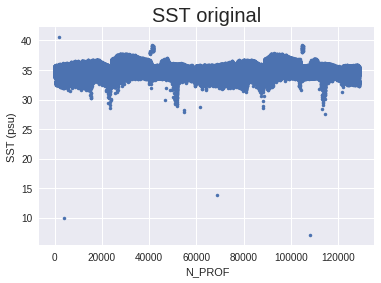

In [0]:
plt.plot(da_al.PSAL[:,0],'.')
plt.title('SST original',fontsize=20)
plt.ylabel('SST (psu)')
plt.xlabel('N_PROF')
#plt.savefig('sst_prof.png',dpi=150)
#files.download("sst_prof.png") 

## **Normalization and selection of data**



In [0]:
scaler = preprocessing.StandardScaler()
scaler.fit(da_s.PSAL)
#st_ave = scaler.mean_
#st_std = scaler.scale_
data_salt=scaler.transform(da_s.PSAL)

scaler.fit(da_s.TEMP)
data_temp=scaler.transform(da_s.TEMP)

In [6]:
xx=data_temp[:,:-30]
yy=data_salt[:,:-30]
xx.shape

(128904, 272)

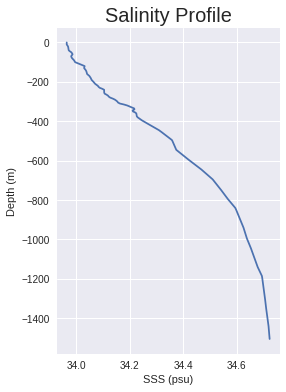

In [0]:
plt.figure(figsize=(4,6))
plt.plot(da_al.PSAL[15000],da_al.DEPTH)#1997
plt.title('Salinity Profile',fontsize=20)
plt.xlabel('SSS (psu)')
plt.ylabel('Depth (m)')
#plt.savefig('sa3.png',dpi=150)
#files.download("sa3.png") 

In [0]:
indices=np.arange(xx.shape[0])
X_tr, X_test, y_tr, y_test,x_ind,ind_test = train_test_split(xx, yy,indices,test_size=0.2)
X_train, X_val, y_train, y_val,ind_train,ind_val = train_test_split(X_tr, y_tr,x_ind,test_size=0.25)
#y_test.shape

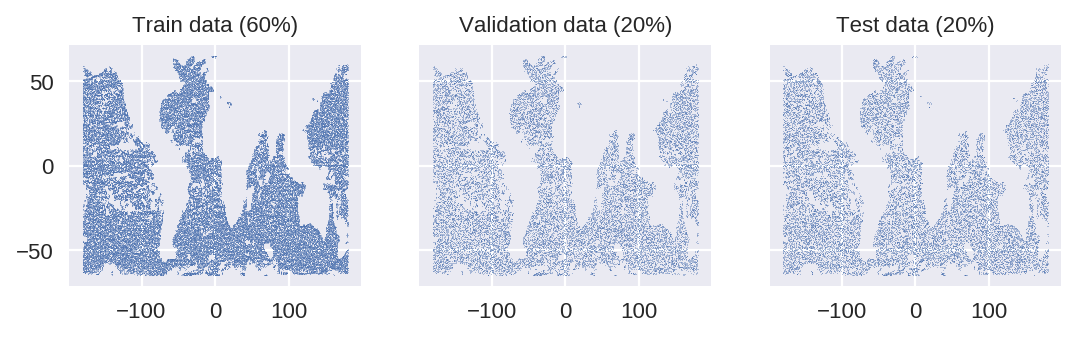

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,2), dpi=160, facecolor='w', edgecolor='k', sharey='row')

X=da_s
colors = X.mean('DEPTH')
ax[0].plot(X.LONGITUDE.values[ind_train], X.LATITUDE.values[ind_train],'.',markersize=0.5)
ax[1].plot(X.LONGITUDE.values[ind_val], X.LATITUDE.values[ind_val],'.',markersize=0.5)
ax[2].plot(X.LONGITUDE.values[ind_test], X.LATITUDE.values[ind_test],'.',markersize=0.5)

ax[0].set_title("Train data (60%)",fontsize=10)
ax[1].set_title("Validation data (20%)",fontsize=10)
ax[2].set_title("Test data (20%)",fontsize=10)
#plt.savefig('selection1.png',dpi=150)
#files.download("selection1.png")
plt.show()

# Create Neural **networks**

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
#from keras import regularizers#kernel_regularizer=regularizers.l2(0.01),

model = Sequential()
model.add(Dense(400, input_shape=(X_train.shape[1],), kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(400,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(X_test.shape[1], activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 400)               109200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 400)               160400    
_________________________________________________________________
dropout_6 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 400)               160400    
_________________________________________________________________
dropout_7 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 400)               160400    
__________

In [0]:
from keras.models import Model
from keras import optimizers
#from keras.optimizers import RMSprop
model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
#model.fit(X_train,y_train, batch_size=1, epochs=30, shuffle=False)
batch_size = 1280
epochs = 30
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val))

Train on 77342 samples, validate on 25781 samples
Epoch 1/30
77342/77342 [==============================] - 8s 100us/step - loss: 0.3940 - val_loss: 0.1410
Epoch 2/30
77342/77342 [==============================] - 7s 96us/step - loss: 0.1620 - val_loss: 0.1072
Epoch 3/30
77342/77342 [==============================] - 8s 98us/step - loss: 0.1313 - val_loss: 0.0798
Epoch 4/30
77342/77342 [==============================] - 8s 97us/step - loss: 0.1152 - val_loss: 0.0692
Epoch 5/30
77342/77342 [==============================] - 9s 118us/step - loss: 0.1062 - val_loss: 0.0748
Epoch 6/30
77342/77342 [==============================] - 8s 108us/step - loss: 0.0987 - val_loss: 0.0746
Epoch 7/30
77342/77342 [==============================] - 7s 95us/step - loss: 0.0874 - val_loss: 0.0803
Epoch 8/30
77342/77342 [==============================] - 8s 99us/step - loss: 0.0858 - val_loss: 0.0795
Epoch 9/30
77342/77342 [==============================] - 8s 100us/step - loss: 0.0845 - val_loss: 0.0701
E

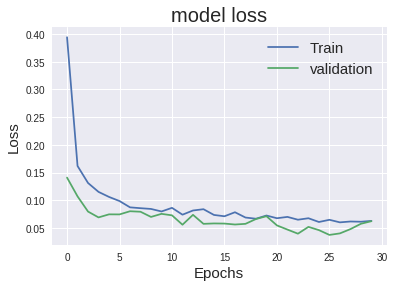

In [24]:
# list all data in history
#print(history.history.keys())

#Visualize history (loss vs epochs)
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=20)
plt.ylabel('Loss', fontsize=15)  
plt.xlabel('Epochs', fontsize=15)
plt.legend(['Train','validation'], loc='upper right', fontsize=15)
#plt.savefig('modloss.png',dpi=150)
#files.download("modloss.png") 
plt.show()

# **Prediction**

In [0]:
y_pred = model.predict(X_test)

In [0]:
def destd(x):
    scaler = preprocessing.StandardScaler()
    scaler.fit(da_s.PSAL[:,:x.size])
    return scaler.inverse_transform(x)

In [0]:
nt=15000
nm=50
dp=da_s.DEPTH[:xx.shape[1]]

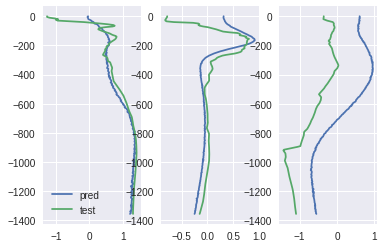

In [28]:
ax1=plt.subplot(131)
ax2=plt.subplot(132)
ax3=plt.subplot(133)
ax1.plot(y_pred[nt],dp,'-',label='pred')
ax1.plot(y_test[nt],dp,'-',label='test')
ax1.legend()
ax2.plot(y_pred[nt+nm],dp,'-',label='pred')
ax2.plot(y_test[nt+nm],dp,'-',label='test')
ax3.plot(y_pred[nt-nm],dp,'-',label='pred')
ax3.plot(y_test[nt-nm],dp,'-',label='test')

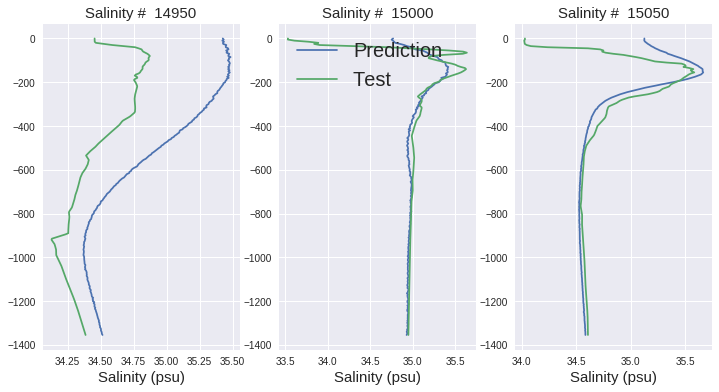

In [29]:
plt.figure(figsize=(12,6))
ax1=plt.subplot(132)
ax2=plt.subplot(133)
ax3=plt.subplot(131)
ax1.plot(destd(y_pred[nt]),dp,'-',label='Prediction')
ax1.plot(destd(y_test[nt]),dp,'-',label='Test')
ax1.legend(fontsize=20)
ax1.set_ylabel('Depth(m)', fontsize=15)
ax1.set_title('Salinity #  %d'%nt, fontsize=15)
ax2.plot(destd(y_pred[nt+nm]),dp,'-',label='pred')
ax2.plot(destd(y_test[nt+nm]),dp,'-',label='test')
ax3.plot(destd(y_pred[nt-nm]),dp,'-',label='pred')
ax3.plot(destd(y_test[nt-nm]),dp,'-',label='test')

ax2.set_title('Salinity #  %d'%(nt+nm), fontsize=15)
ax3.set_title('Salinity #  %d'%(nt-nm), fontsize=15)
ax1.set_xlabel('Salinity (psu)', fontsize=15)
ax2.set_xlabel('Salinity (psu)', fontsize=15)
ax3.set_xlabel('Salinity (psu)', fontsize=15)
#plt.savefig('pred_pf.png',dpi=150)
#files.download("pred_pf.png") 
plt.show()

# average RME at each step 

(array([-1600., -1400., -1200., -1000.,  -800.,  -600.,  -400.,  -200.,
            0.,   200.]), <a list of 10 Text yticklabel objects>)

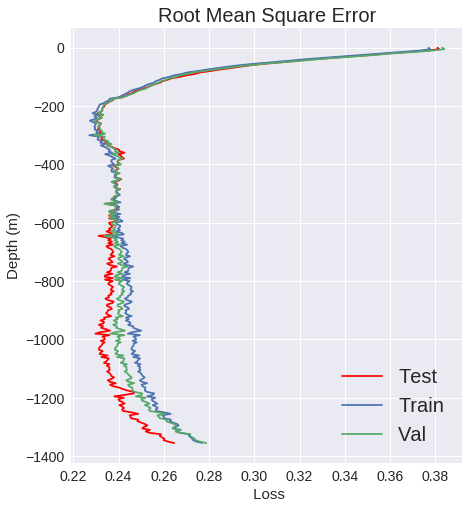

In [30]:
from sklearn.metrics import mean_squared_error

def finde(x_e,y_e):
    y_pred=model.predict(x_e)       
    return np.sqrt(mean_squared_error(y_pred,y_e,multioutput='raw_values')) 
  
e1=finde(X_test,y_test)

plt.figure(figsize=(7,8))
plt.plot(e1,dp,'r',label='Test') 
e2=finde(X_train,y_train)
plt.plot(e2,dp,label='Train') 
e3=finde(X_val,y_val)
plt.plot(e3,dp,label='Val')
plt.ylabel('Depth (m)',fontsize=15)
plt.xlabel(' Loss',fontsize=15)
plt.title('Root Mean Square Error',fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig('modloss1.png',dpi=150)
#files.download("modloss1.png") 

# average RME at each profiles

In [0]:
def finde1(x_e,y_e):
    y_pred=model.predict(x_e)

    err=np.zeros(y_e.shape[0])
    for i in range(y_e.shape[0]):
        err[i]=np.sqrt(((y_pred[i]-y_e[i])**2).mean())
    return err
  
#eh1=finde1(X_test,y_test)

In [0]:
eh_all=finde1(xx,yy)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

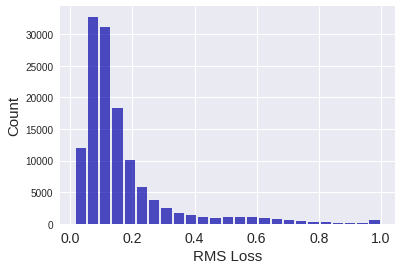

In [33]:
eh1_a=np.where(eh_all < 1,eh_all, 1)
plt.hist(eh1_a,bins=25,color='#0504aa',alpha=0.7, rwidth=0.85)
plt.ylabel('Count',fontsize=15)
plt.xlabel('RMS Loss',fontsize=15)
plt.xticks(fontsize=14)
##n, bins, patches = plt.hist(x=eh_all, bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
#plt.savefig('his.png',dpi=150)
#files.download("his.png") 

# Plot

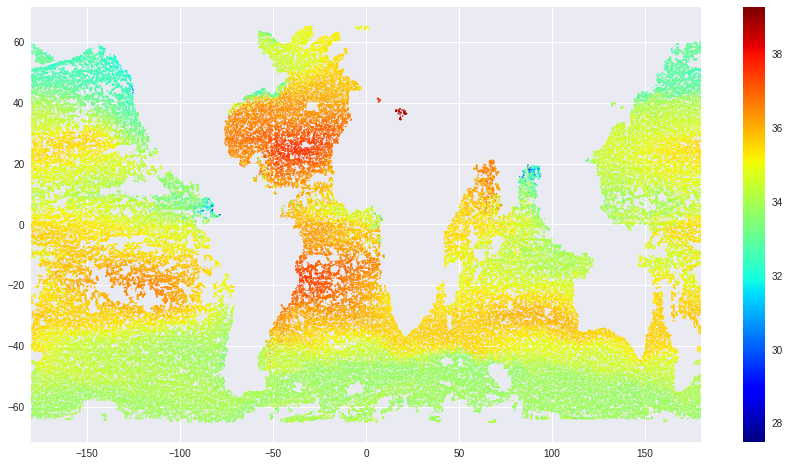

In [0]:
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
m.fillcontinents()
#draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.),labels=[1,0,0,0],fontsize=15)
m.drawmeridians(np.arange(-180.,181.,60.),labels=[0,0,0,1],fontsize=15)

X=da_s.PSAL#[:,0]
colors = X.mean('DEPTH')
plt.scatter(X.LONGITUDE,X.LATITUDE, 1, colors,cmap='jet',)
cb=m.colorbar()
cb.ax.tick_params(labelsize=15)
#plt.title("In-situ density (kg/m3)")
fig = plt.gcf()
fig.set_size_inches(15,8 )
plt.title('Global average salinity (psu)',fontsize=20)
#plt.savefig('Save.jpg',dpi=150)
plt.show()

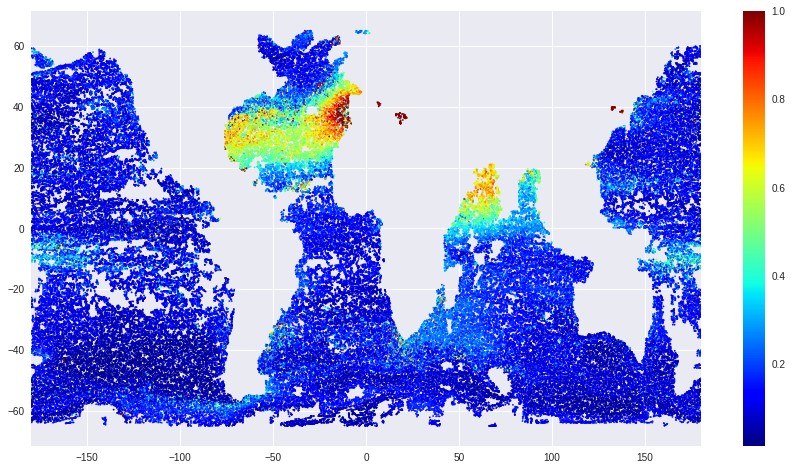

In [34]:
eh1_a=np.where(eh_all < 1.,eh_all, 1)

plt.figure(figsize=(15,8))
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
m.fillcontinents()
#draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.),labels=[1,0,0,0],fontsize=15)
m.drawmeridians(np.arange(-180.,181.,60.),labels=[0,0,0,1],fontsize=15)

X=da_s
colors = eh1_a
plt.scatter(X.LONGITUDE, X.LATITUDE, 1, colors,cmap='jet')
cb=m.colorbar()
cb.ax.tick_params(labelsize=15)

plt.title('RME Loss Total',fontsize=20)
#plt.savefig('RME Loss Total.jpg',dpi=150)
plt.show()

In [0]:
eh1_a=np.where(eh_all < 1,eh_all, 1)
ehh=np.where(eh1_a>0.4,eh1_a,np.nan)

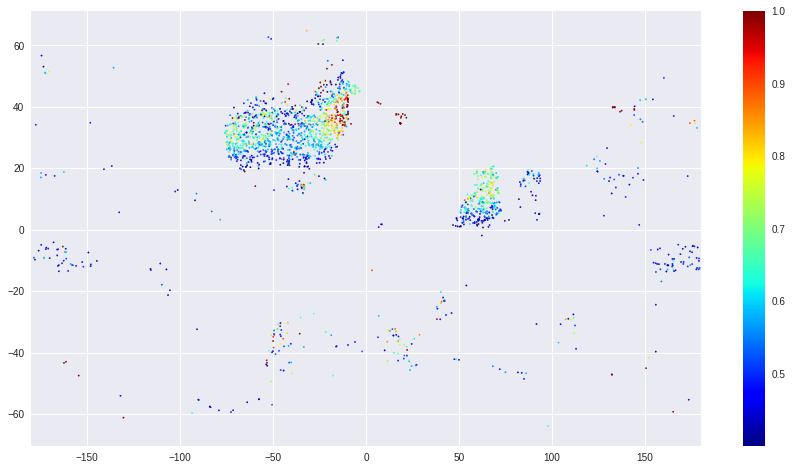

In [0]:
#eh1_a=np.where(eh_all < 0.4,eh_all, 0.4)
#eh1_a=np.where(eh_all < 0.8,eh_all, 0.8)

plt.figure(figsize=(15,10))
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
m.fillcontinents()
#draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.),labels=[1,0,0,0],fontsize=15)
m.drawmeridians(np.arange(-180.,181.,60.),labels=[0,0,0,1],fontsize=15)

X=da_s
#colors = eh1_a[ind_test]
colors = ehh[ind_test]
plt.scatter(X.LONGITUDE.values[ind_test], X.LATITUDE.values[ind_test], 10, colors,cmap='jet')
cb=m.colorbar()
cb.ax.tick_params(labelsize=15)
plt.title('RME Loss Test ',fontsize=20)#(loss>0.4)
#plt.savefig('RME Loss Testal.jpg',dpi=150)
plt.show()

# Find the abnormalities of profile

In [38]:
lt_eh=eh_all.tolist()
f_eh=sorted(i for i in lt_eh if i >= 0.7)
len(f_eh)

2252

In [39]:
idx=lt_eh.index(f_eh[500])
idx

45516

In [0]:
y_predal = model.predict(xx)

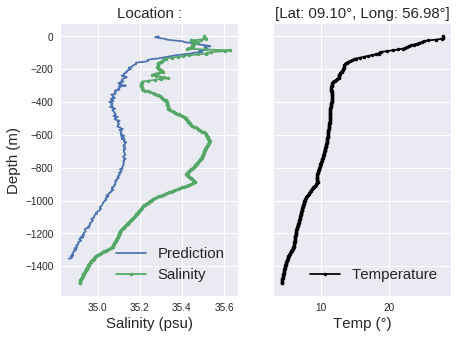

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2,  facecolor='w',figsize=(7,5), edgecolor='k', sharey='row')#figsize=(4,5)

h1=da_s.isel(N_PROF=idx) #37533

ax[0].plot(destd(y_predal[idx]),dp,label='Prediction')
ax[0].plot(h1.PSAL.values,h1.DEPTH,'.-',label='Salinity')
ax[1].plot(h1.TEMP.values,h1.DEPTH,'.-',color='k',label='Temperature')

ax[0].set_title('Location :',fontsize=15)
ax[1].set_title('[Lat: {:05.2f}°, Long: {:05.2f}°]'.format(h1.LATITUDE.values,h1.LONGITUDE.values),fontsize=15)
ax[1].set_xlabel('Temp (°)',fontsize=15)
ax[0].set_xlabel('Salinity (psu)',fontsize=15)
ax[0].set_ylabel('Depth (m)',fontsize=15)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
#plt.savefig('sd.png',dpi=150)
#files.download("sd.png") 